In [1]:
import torchvision
import torch
from torchvision import transforms
from tqdm.auto import tqdm
import random
import numpy as np
from models import vgg,layers
from torchvision.utils import _log_api_usage_once
import sys

sys.path.append("../")


def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6

manual_seed(42)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
int_model = vgg.int_vgg16(bias=False)

int_model.load_state_dict(torch.load('./checkpoint/minmax_no_bias.pth')['model_state_dict'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
int_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    # transforms.ConvertImageDtype(torch.int8)
    # NHWC 로 해야한다.
])

val_data = torchvision.datasets.CIFAR100(root="./dataset", train=False, transform=int_transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False,pin_memory=True,num_workers=4)
next_data = next(iter(val_loader))[0]
print(next_data.shape, next_data.max(), next_data.min())



torch.Size([32, 3, 224, 224]) tensor(1.) tensor(0.)


In [4]:
modules = []
before_l = []
after_l = []
hooks = []

def hook_fn(module, input, output):
    modules.append(module)
    before_l.append(input[0])
    after_l.append(output)

def add_forward_hook(net, hooks):
    for name, layer in net._modules.items():
        if isinstance(layer, torch.nn.Sequential) or isinstance(layer, vgg.VGG) or isinstance(layer, vgg.INTVGG):
            add_forward_hook(layer, hooks)
        else:
            if isinstance(layer, torch.nn.ReLU) or isinstance(layer, layers.QuantReLU) \
                or isinstance(layer, torch.nn.ReLU) or isinstance(layer, layers.QuantReLU) \
                or isinstance(layer, torch.ao.nn.quantized.Conv2d) or isinstance(layer, torch.ao.nn.quantized.Linear):
                # or isinstance(layer, layers.FLOATConv2d) or isinstance(layer, layers.FLOATLinear):
                hook = layer.register_forward_hook(hook_fn)
                hooks.append(hook)
            
    return hooks

def remove_forward_hook(hooks):
    for i in hooks:
        i.remove()

In [5]:
# integer model hook
hooks = add_forward_hook(int_model, hooks)
with torch.no_grad():
    int_model.cuda()
    int_model.eval()
    for i,data in enumerate(tqdm(val_loader,leave=True)):
        imgs = torch.tensor(data[0].clone().detach()/0.0079, dtype=torch.int8)
        imgs = imgs.permute(0,2,3,1)
        imgs = torch.cat([imgs, torch.zeros((data[0].size(0),224,224,1), dtype=torch.int8)], dim=-1).contiguous()
        imgs = imgs.to(device)
        output = int_model(imgs)
        break

remove_forward_hook(hooks)

int_activation_after = after_l.copy()

print(modules)
print(len(after_l))
modules= []
before_l = []
after_l = []
hooks=[]



  0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_3407505/302929933.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(data[0].clone().detach()/0.0079, dtype=torch.int8)
  0%|          | 0/313 [00:01<?, ?it/s]

[QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU()]
15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


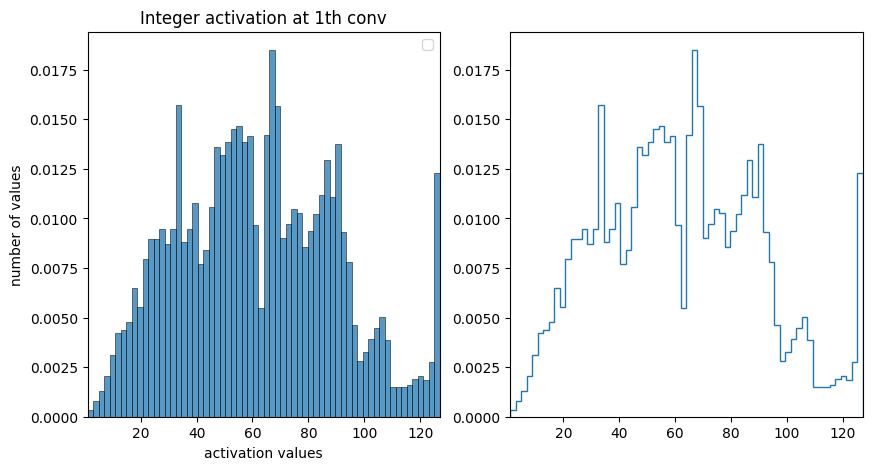

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


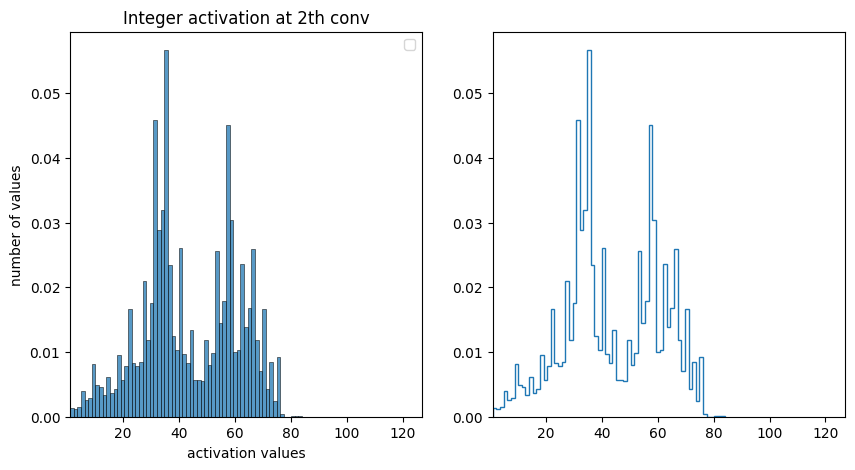

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


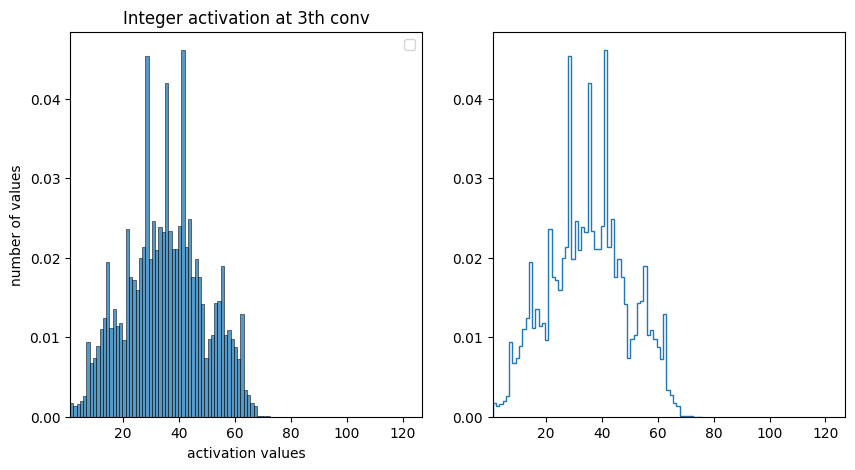

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


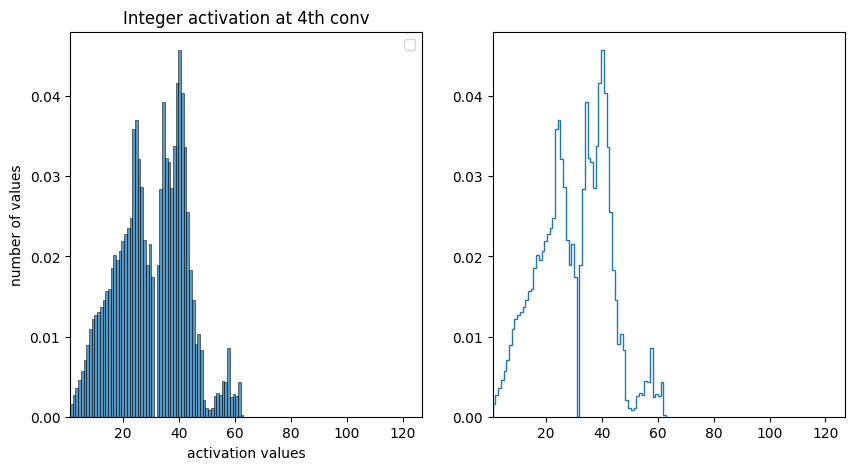

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


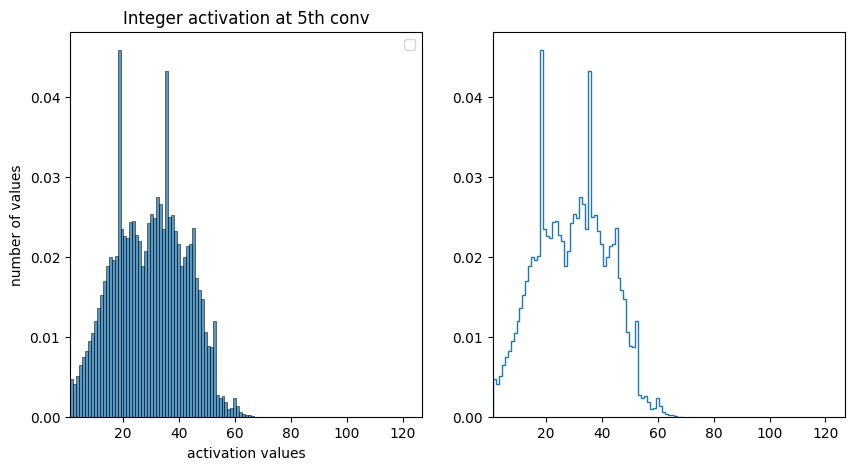

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


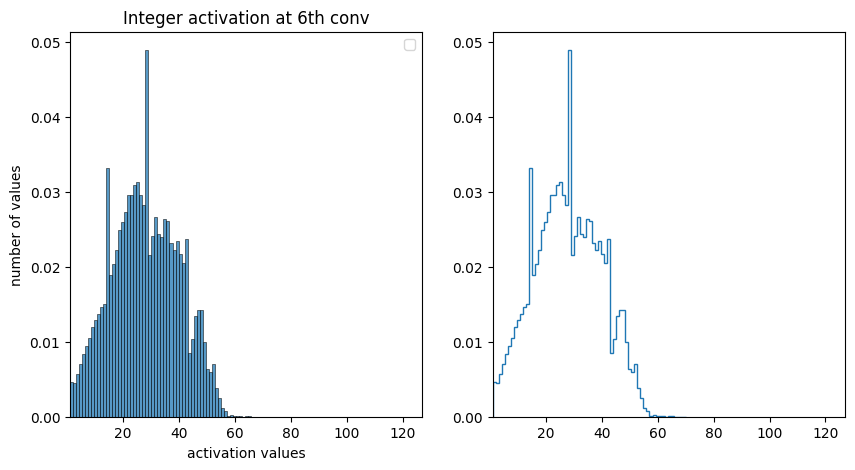

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


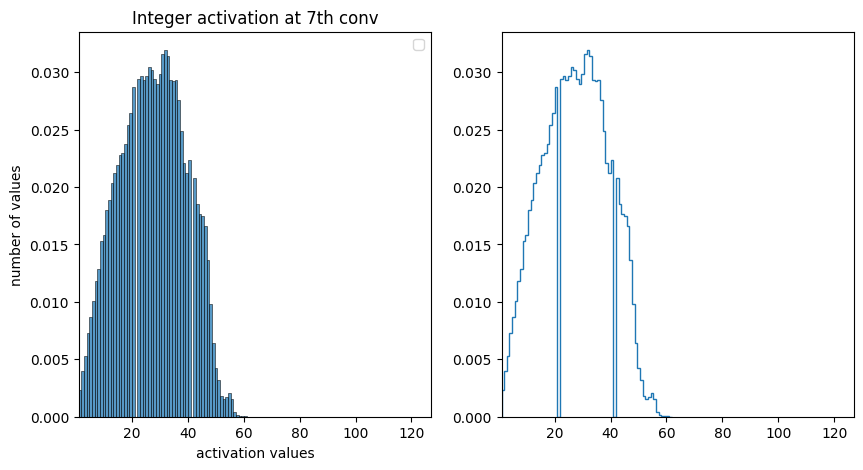

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


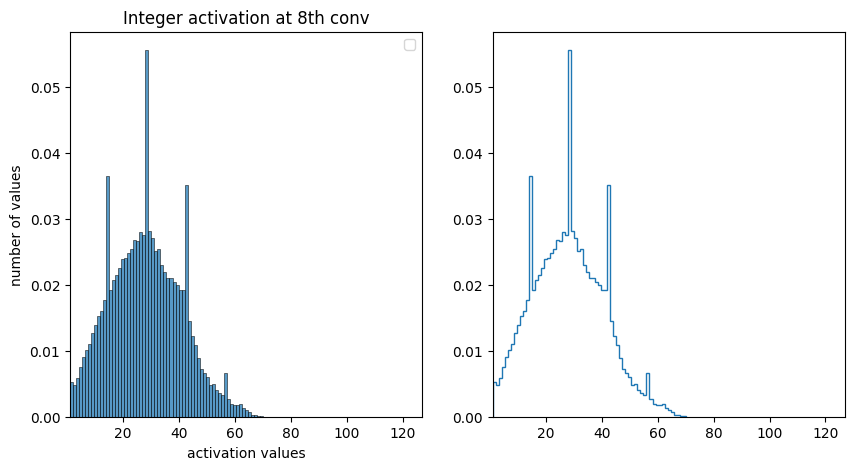

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


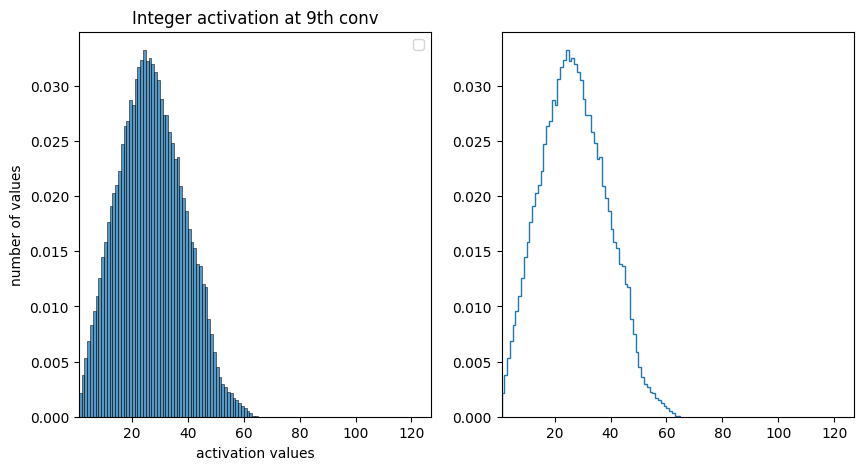

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


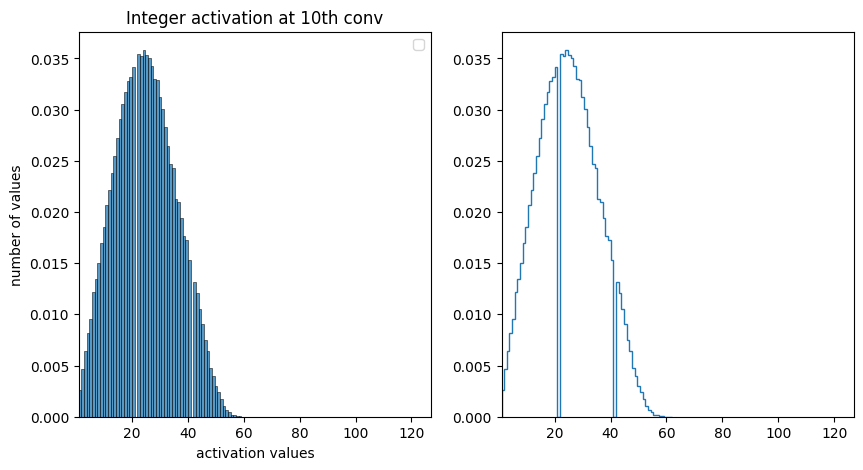

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


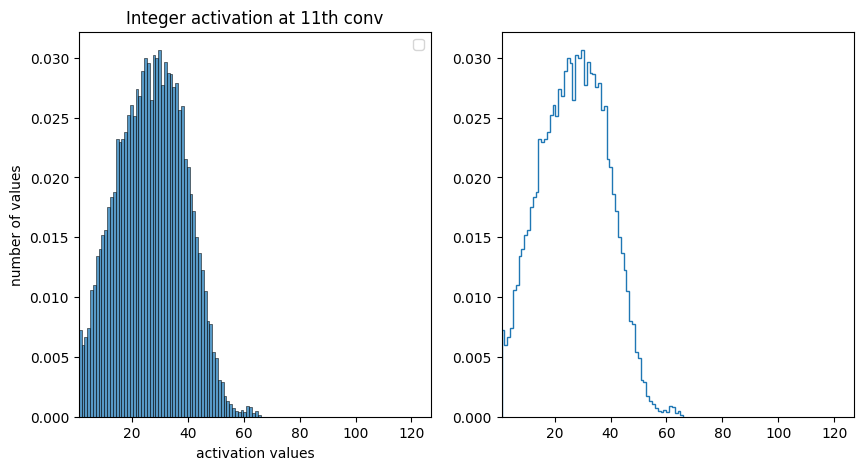

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


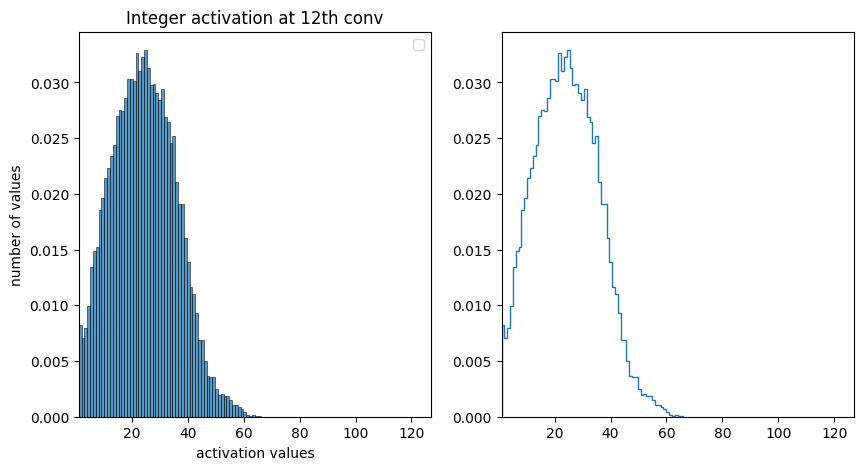

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


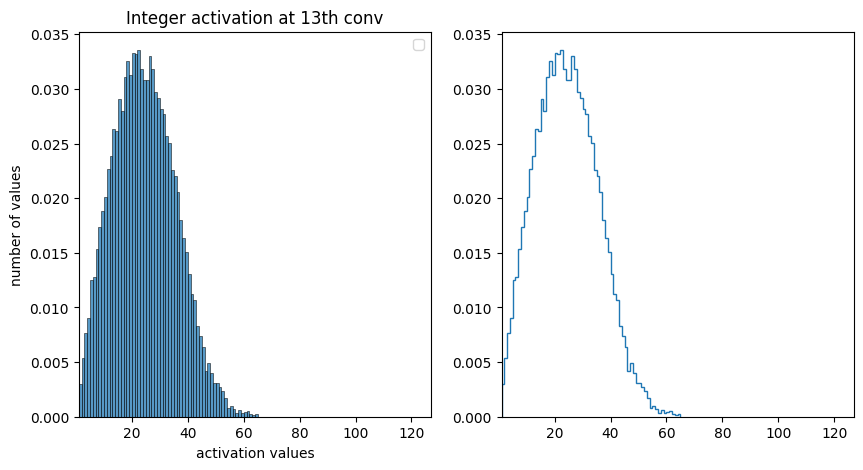

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


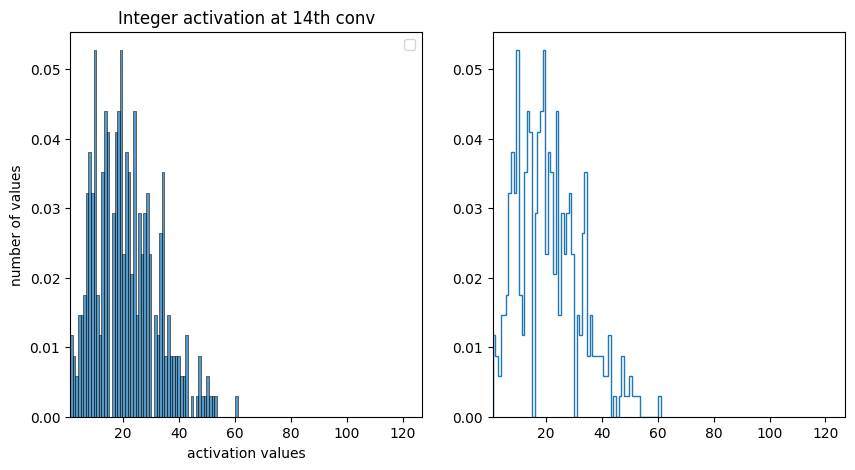

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


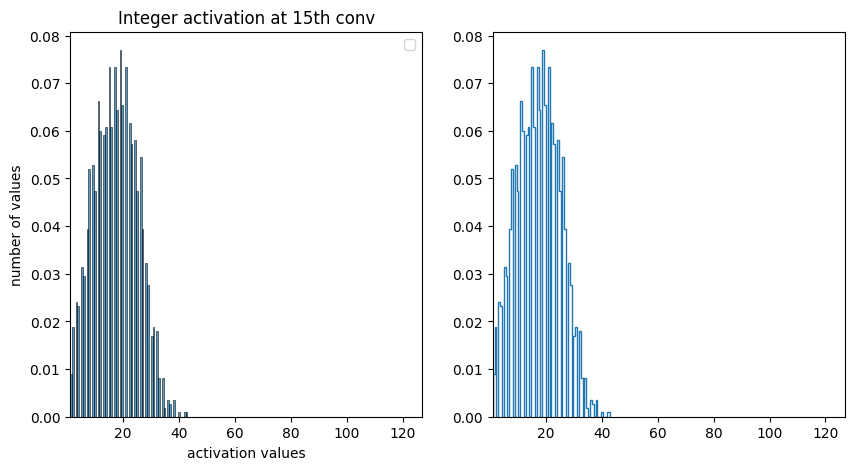

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# print(len(torch_static_conv[i]))
# a = int_activation_after[0][0].contiguous().view(-1).tolist()
# a = [x for x in a if x!=0]
# print(len(a), type(min(a)), max(a))
for i in range(len(int_activation_after)):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)

    # max_val = max(max_val, max(conv_weights[i]))
    # min_val = min(min_val, min(conv_weights[i]))
    a = int_activation_after[i][0].contiguous().view(-1).tolist()
    a = [x for x in a if x!=0]
    sns.histplot(a, stat='density', bins= 64)
    # plt.hist(a, bins=127, histtype='step', density=True, label=f"integer conv{i}")
    plt.title(f"Integer activation at {i+1}th conv")
    m = torch.max(torch.abs(int_activation_after[i][0])).item()
    plt.ylabel("number of values")
    plt.xlabel("activation values")
    plt.xlim(1,127)
    # plt.ylim(0,0.05)
    # plt.axvline(0, color='black', linestyle='-', linewidth=1, zorder=0)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.hist(a, bins=64, histtype='step', density=True, label=f"integer conv{i}")
    plt.xlim(1,127)
    plt.show()